In [321]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Set display options to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column


### <font color="orange">  **Imports, Data Loading and Preprocessing** </font>

In [322]:
df = pd.read_csv('health_insurance_train.csv')
df_autograder = pd.read_csv('health_insurance_autograde.csv')
pd.options.display.float_format = '{:.2f}'.format

# Define a function to convert education ranges to numerical values
def convert_education(education):

    education = education.replace('years', '')

    if '>16' in education:
        return 20
    
    if '<9' in education:
        return 4.5

    education = education.split('-')
    education = (float(education[-1])+float(education[0]))/2

    return education

# Define a function to convert yes/no values to binary values
def yes_no_True_False_to_binary(value):
    if value == 'yes' or value == 'no':
        if value == 'yes':
            return 1
        else:
            return -1
        
    if value == True or value == False:
        if value == True:
            return 1
        else:
            return 0

    return value

# Define a function to convert NaN values to the mean of the column
def nan_to_mean(value, mean):
    if pd.isna(value):
        return mean
    return value

# Define a function apply all conversion functions to the dataframe
def preprocess_data(df):
    # Apply the conversion functions to the education column
    df['education'] = df['education'].apply(convert_education)

    # Apply one-hot encoding to the race and region column

    ''''
    One hot encoding is a process by which categorical variables are converted into
    binary True/False. ML algorithm will read True as 1 and False as 0. So gradients
    can be made for each column separetely.

    '''
    df = pd.get_dummies(df, columns=['race'], prefix='race')
    df = pd.get_dummies(df, columns=['region'],prefix='reg')
    df = pd.get_dummies(df, columns=['hispanic'],prefix='hisp')


    # Apply binary conversion to all remaining columns that contain yes/no or True/False values
    for key in df.keys():
        df[key] = df[key].apply(yes_no_True_False_to_binary)

    # Apply the mean conversion to all columns that contain NaN values
    ''''
    Now that all columns are already converted to numerical values, we can apply the
    mean conversion to all columns that contain NaN values.

    '''

    for key in df:
        mean = df[key].mean()
        df[key] = df[key].apply(lambda x: nan_to_mean(x, mean))

    return df

df = preprocess_data(df)
df_autograder = preprocess_data(df_autograder)

In [323]:
df.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,40.00,-1,1,1,14.00,17.00,0.00,1.00,22.00,0,0,1,0,0,1,0,1,0
1,40.00,-1,1,1,14.00,4.00,1.00,0.00,15.00,0,0,1,0,0,1,0,1,0
2,0.00,1,-1,1,16.00,21.00,0.00,1.00,100.00,0,0,1,0,1,0,0,1,0
3,40.00,-1,-1,1,14.00,22.00,0.34,0.70,60.00,0,0,1,1,0,0,0,1,0
4,35.00,-1,1,-1,12.00,15.00,0.00,2.00,0.00,0,0,1,0,0,1,0,1,0


In [324]:
df_autograder.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,16.00,25.00,0.00,0.00,0.00,0,0,1,0,0,0,1,1,0
1,-1,-1,-1,12.00,41.00,0.00,0.00,0.00,0,0,1,0,0,1,0,1,0
2,1,1,1,20.00,21.00,0.00,2.00,34.30,0,0,1,0,1,0,0,1,0
3,-1,1,1,10.00,46.50,0.00,0.00,0.00,0,0,0,0,1,0,0,1,0
4,-1,-1,-1,14.00,9.00,0.00,0.00,25.00,0,0,1,1,0,0,0,1,0


In [325]:
########### Pipeline Configuration ##############

scale_data = True
filter_outliers = True

#Pipeline 1 --> True,False
#Pipeline 2 --> True,True
#################################################

if scale_data:
    def specific_normalization(df, mean, std, columns_index=[0, 4, 5, 6, 7, 8]):
        for i in range(len(df.columns)):
            if i in columns_index:
                df.iloc[:, i] = (df.iloc[:, i] - mean.iloc[i]) / std.iloc[i]
        return df

    df_mean = df.mean(axis=0)
    df_std = df.std(axis=0)

    print(df_mean.drop(columns=['whrswk']))

    df = specific_normalization(df, df_mean, df_std, columns_index=[0, 4, 5, 6, 7, 8])
    df_autograder = specific_normalization(df_autograder, df_mean.iloc[1:], df_std.iloc[1:], columns_index=[3,4,5,6,7])


whrswk             25.67
hhi                -0.01
whi                -0.24
hhi2                0.22
education          13.11
experience         22.89
kidslt6             0.34
kids618             0.70
husby              27.30
race_black          0.05
race_other          0.01
race_white          0.84
reg_northcentral    0.25
reg_other           0.24
reg_south           0.30
reg_west            0.21
hisp_no             0.93
hisp_yes            0.07
dtype: float64


In [317]:
df.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,0.77,-1,1,1,0.28,-0.51,-0.55,0.31,-0.22,0,0,1,0,0,1,0,1,0
1,0.77,-1,1,1,0.28,-1.63,1.07,-0.75,-0.52,0,0,1,0,0,1,0,1,0
2,-1.37,1,-1,1,0.92,-0.16,-0.55,0.31,3.06,0,0,1,0,1,0,0,1,0
3,0.77,-1,-1,1,0.28,-0.08,0.00,-0.00,1.38,0,0,1,1,0,0,0,1,0
4,0.50,-1,1,-1,-0.36,-0.68,-0.55,1.37,-1.15,0,0,1,0,0,1,0,1,0


In [318]:
df_autograder.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,16.17,25.00,0.00,0.00,0.00,0,0,1,0,0,0,1,1,0
1,-1,-1,-1,12.07,41.00,0.00,0.00,0.00,0,0,1,0,0,1,0,1,0
2,1,1,1,20.26,21.00,0.00,2.00,34.30,0,0,1,0,1,0,0,1,0
3,-1,1,1,10.02,46.50,0.00,0.00,0.00,0,0,0,0,1,0,0,1,0
4,-1,-1,-1,14.12,9.00,0.00,0.00,25.00,0,0,1,1,0,0,0,1,0


Threshold (at 98th percentile): 6.037666632670696


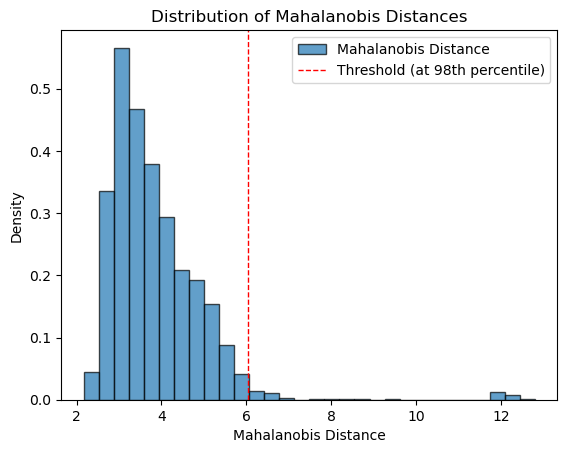

Outliers found
Number of outliers: 100


In [248]:
if filter_outliers:
    from scipy.stats import chi2

    df_numeric = df.select_dtypes(include=[np.number]) # Select only numerical columns

    # Calculate the mean vector and covariance matrix
    mean_vector = df_numeric.mean(axis=0)
    cov_matrix = np.cov(df_numeric.values.T)

    # Add a small regularization term to the covariance matrix such that it's not singular
    # Since we are using classification data, 

    regularization_term = 1e-5 * np.eye(cov_matrix.shape[0])
    cov_matrix += regularization_term


    #--------- Compute the Mahalanobis distance for each observation
    def mahalanobis_distance(row, mean_vector, cov_matrix):

        '''
        The Mahalanobis distance assumes that the data follows a multivariate normal distribution. 

        1. Calculate the difference vector (diff) between the observation and the mean.
        2. Transpose the difference vector (diff.T).
        3. Multiply the transposed difference vector by the inverse covariance matrix (diff.T @ inv_cov_matrix).
        4. Multiply the result by the original difference vector (diff.T @ inv_cov_matrix @ diff).
        5. Take the square root of the result to get the Mahalanobis distance (md).
        '''

        diff = row - mean_vector
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        md = np.sqrt(diff.T @ inv_cov_matrix @ diff) 
        return md

    # Apply the Mahalanobis distance function to each row
    # lamda makes row is a anonymous function that takes a single argument row, it is necessary to pass row as an argument to .apply
    # What apply sees is a function that takes a single argument, so it passes each row to this function
    df['mahalanobis'] = df_numeric.apply(lambda row: mahalanobis_distance(row, mean_vector, cov_matrix), axis=1) 

    #--------- Determine the threshold for identifying outliers
    percentile = 98
    threshold = np.percentile(df['mahalanobis'], percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")

    # Plot the distribution of Mahalanobis distances
    plt.hist(df['mahalanobis'], bins=30, edgecolor='k', alpha=0.7, density=True, label='Mahalanobis Distance')

    # Add the threshold line
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold (at {percentile}th percentile)')

    # Add titles and labels
    plt.title('Distribution of Mahalanobis Distances')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Identify outliers
    outliers = df[df['mahalanobis'] > threshold]
    
    if not outliers.empty:
        print("Outliers found")
        print(f"Number of outliers: {len(outliers)}")
    else:
        print("No outliers found")
    
    # Filter out the rows that contain outliers
    df = df[df['mahalanobis'] <= threshold]

    # Drop the 'mahalanobis' column as it's no longer needed
    df.drop(columns=['mahalanobis'], inplace=True)

# Split the data into features and target
X = df.drop(columns=['whrswk'])
y = df['whrswk']